In [1]:
import torch
model = torch.hub.load('facebookresearch/pytorchvideo', 'x3d_xs', pretrained=True)
model = torch.hub.load('facebookresearch/pytorchvideo', 'x3d_s', pretrained=True)
model = torch.hub.load('facebookresearch/pytorchvideo', 'x3d_m', pretrained=True)

Using cache found in /home/omi/.cache/torch/hub/facebookresearch_pytorchvideo_master
Using cache found in /home/omi/.cache/torch/hub/facebookresearch_pytorchvideo_master
Using cache found in /home/omi/.cache/torch/hub/facebookresearch_pytorchvideo_master


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data import DistributedSampler, RandomSampler, SequentialSampler


from torchvision import transforms


from pytorchvideo.models import x3d
from pytorchvideo.data import (
    Ucf101, 
    RandomClipSampler, 
    UniformClipSampler, 
    Kinetics,
    SSv2
)


from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
)


import torchinfo

from tqdm.notebook import tqdm
import itertools
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Args:
    def __init__(self):
        self.metadata_path = '/mnt/NAS-TVS872XT/dataset/'
        self.root = self.metadata_path
        self.annotation_path = self.metadata_path
        self.FRAMES_PER_CLIP = 16
        self.STEP_BETWEEN_CLIPS = 16
        self.BATCH_SIZE = 16
        self.NUM_WORKERS = 8  # kinetics:8, ucf101:24
        # self.CLIP_DURATION = 16 / 25
        self.CLIP_DURATION = (8 * 8) / 30  # (num_frames * sampling_rate)/fps
        self.VIDEO_NUM_SUBSAMPLED = 8  # 事前学習済みモデルに合わせて16→8
        self.UCF101_NUM_CLASSES = 101
        self.KINETIC400_NUM_CLASSES = 400
        self.MODEL_NAME = "x3d_m"

args = Args()

In [3]:
class LimitDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        self.dataset_iter = itertools.chain.from_iterable(
            itertools.repeat(iter(dataset), 2)
        )

    def __getitem__(self, index):
        return next(self.dataset_iter)

    def __len__(self):
        return self.dataset.num_videos

In [19]:
def get_kinetics(subset):
    """
    Kinetics400のデータセットを取得

    Args:
        subset (str): "train" or "val" or "test"

    Returns:
        pytorchvideo.data.labeled_video_dataset.LabeledVideoDataset: 取得したデータセット
    """
    args = Args()
    transform = Compose([
        ApplyTransformToKey(
            key="video",
            transform=Compose([
                UniformTemporalSubsample(args.VIDEO_NUM_SUBSAMPLED),
                transforms.Lambda(lambda x: x / 255.),
                # Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225)),
                ShortSideScale(size=256),
                # RandomShortSideScale(min_size=256, max_size=320,),
                # CenterCropVideo(crop_size=(256, 256)),
                CenterCrop(224),
                # RandomCrop(224),
                RandomHorizontalFlip(),
            ]),
        ),
        ApplyTransformToKey(
            key="label",
            transform=transforms.Lambda(lambda x: x),
        ),
        RemoveKey("audio"),
    ])

    root_kinetics = '/mnt/NAS-TVS872XT/dataset/Kinetics400/'

    if subset == "test":
        dataset = Kinetics(
            data_path=root_kinetics + "test_list.txt",
            video_path_prefix=root_kinetics + 'test/',
            clip_sampler=RandomClipSampler(clip_duration=args.CLIP_DURATION),
            video_sampler=RandomSampler,
            decode_audio=False,
            transform=transform,
        )
        return dataset
    else:
        dataset = Kinetics(
            data_path=root_kinetics + subset,
            video_path_prefix=root_kinetics + subset,
            clip_sampler=RandomClipSampler(clip_duration=args.CLIP_DURATION),
            video_sampler=RandomSampler,
            decode_audio=False,
            transform=transform,
        )
        return dataset

    return False

In [20]:
def make_loader(dataset):
    """
    データローダーを作成

    Args:
        dataset (pytorchvideo.data.labeled_video_dataset.LabeledVideoDataset): get_datasetメソッドで取得したdataset

    Returns:
        torch.utils.data.DataLoader: 取得したデータローダー
    """
    args = Args()
    loader = DataLoader(LimitDataset(dataset),
                        batch_size=args.BATCH_SIZE,
                        drop_last=True,
                        num_workers=args.NUM_WORKERS)
    return loader

In [13]:
dataset = get_kinetics("val")

In [14]:
# data = dataset.__next__()
# data = data["video"]
# print(data.shape)

In [15]:
dataloader = make_loader(dataset)
data_from_loader = iter(dataloader).__next__()

KeyboardInterrupt: 

In [32]:
batch = data_from_loader["video"]

print(batch.shape)

torch.Size([8, 3, 8, 224, 224])


In [11]:
# batch = batch.permute(0,2,1,3,4)
# print(batch.shape)

In [12]:
# video_data_list = []
# for i in range(args.BATCH_SIZE):
#     video_data_list.append(batch[i])

In [13]:
# print(video_data_list[0].shape)

In [14]:
# new_batch = torch.cat(video_data_list, dim=0)
# print(new_batch.shape)

In [15]:
# def change_dim(list):
#     new_batch = torch.cat(list, dim=0)
#     return new_batch

In [16]:
# test_list = []
# input_0 = torch.zeros(16,3,224,224)
# input_1 = torch.ones(16,3,224,224)
# test_list.append(input_0)
# test_list.append(input_1)
# # print(test_list[1])
# test_batch = change_dim(test_list)
# print(test_batch.shape)
# # print(test_batch[16:32, :])

5次元を4次元に変更完了

In [17]:
# # ダミーデータ用意
# dummy_data_list = []

# for i in range(args.BATCH_SIZE):
#     dummy_data = torch.linspace(i, i, 3*16*224*224)
#     dummy_data = dummy_data.view(16,3,224,224)
#     dummy_data_list.append(dummy_data)

# print(dummy_data_list[0].shape)
# # print(dummy_data_list[5])  # 全ての要素が5（後でシフトが上手くできたか確認できるように）

In [18]:
# dummy_batch = change_dim(dummy_data_list)
# print(dummy_batch.shape)
# # print(dummy_batch[16*5:16*6,:])

In [19]:
# dummy_data_list_from_batch = []
# for i in range(args.BATCH_SIZE):
#     dummy_data_from_batch = dummy_batch[i*16:(i+1)*16, :, :, :]
#     # if i == 5:
#     #     print(dummy_data_from_batch.shape)
#     #     print(dummy_data_from_batch)
#     dummy_data_list_from_batch.append(dummy_data_from_batch)

# # print(dummy_data_list_from_batch[5])
    

### ビデオデータをフレームに分割し画像認識モデルに流すための実験

In [21]:
dataset = get_kinetics("val")
dataset.video_sampler._num_samples = 100

dataloader = make_loader(dataset)

In [22]:
def make_new_batch(inputs, labels):
    """
    動画データを画像データに分割

    Args:
        inputs torch.Tensor: inputs
        labels torch.Tensor: labels

    Returns:
        new_inputs torch.Tensor: new_inputs
        new_labels torch.Tensor: new_labels
    """

    num_frame = inputs.size()[2]
    inputs = inputs.permute(0,2,1,3,4)
    video_data_list = []
    for i in range(inputs.size()[0]):
        video_data_list.append(inputs[i])
    new_inputs = torch.cat(video_data_list, dim=0)

    label_list = []

    for i in range(labels.size()[0]):
        target_id = labels[i].item()
        label = torch.full((1,num_frame), target_id)
        label_list.append(label)
    new_labels = torch.cat(label_list, dim=1)
    new_labels = torch.squeeze(new_labels)

    return new_inputs, new_labels

torch.Size([128, 3, 224, 224])


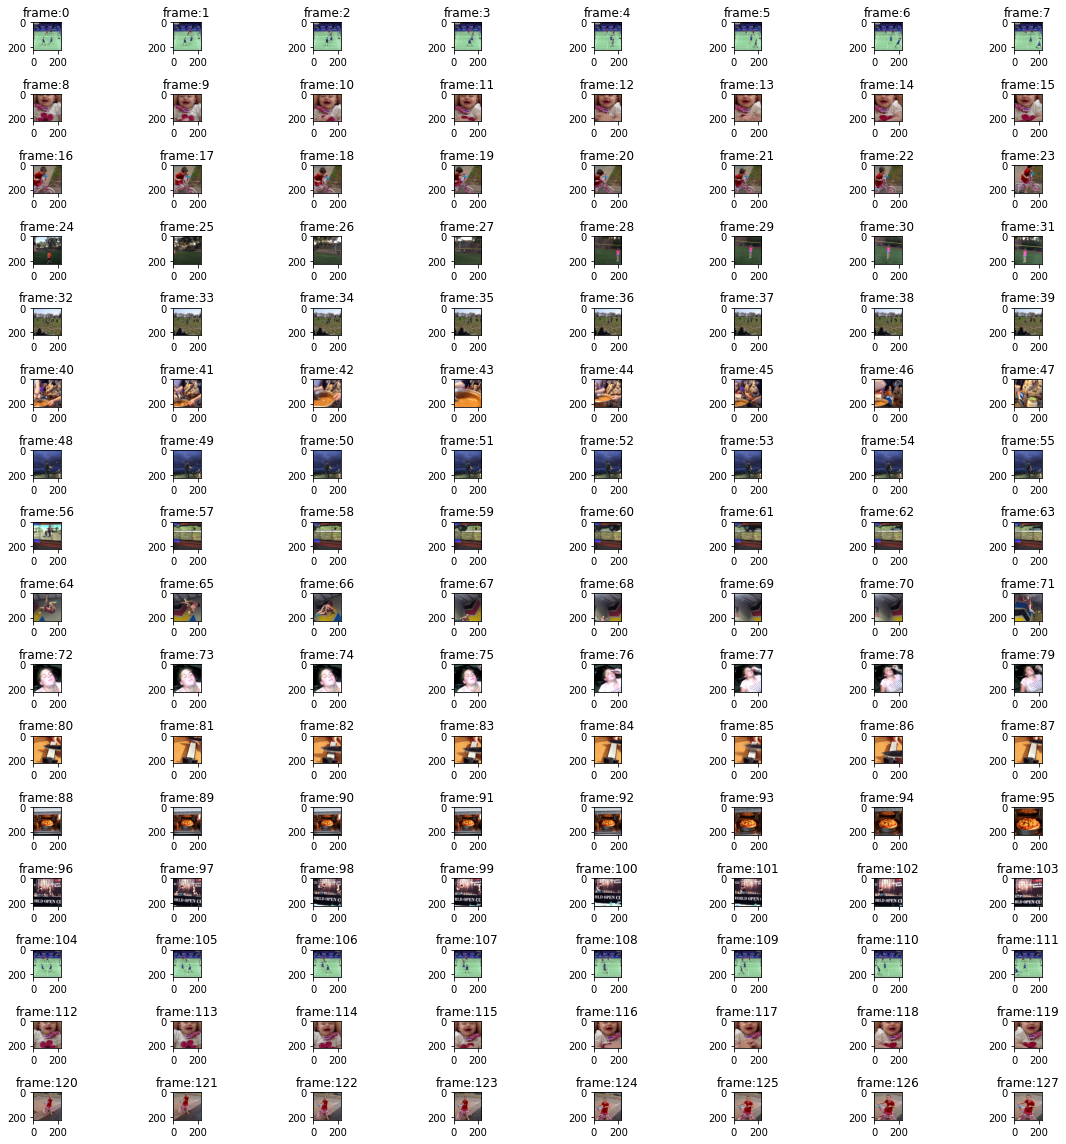

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epoch = 1

with tqdm(range(num_epoch)) as pbar_epoch:
    for epoch in pbar_epoch:
        pbar_epoch.set_description("[Epoch {}]".format(epoch))

        with tqdm(enumerate(dataloader),
                  total=len(dataloader),
                  leave=True) as pbar_batch:
            
            for batch_idx, batch in pbar_batch:
                inputs = batch['video'].to(device)
                targets = batch['label'].to(device)
                if batch_idx == 0:
                    new_inputs, new_targets = make_new_batch(inputs,targets)
                    
                    # サイズの確認
                    # print(inputs.shape)
                    # print(inputs.size(2))
                    print(new_inputs.shape)
                    # print(targets.shape)
                    # print(new_targets.shape)

                    # 要素の確認
                    # print(inputs)
                    # print(new_inputs)
                    # print(targets)
                    # print(new_targets)

                    # test
                    rows = 16
                    cols = 8
                    frame_id = 0

                    fig, axes = plt.subplots(rows,cols,figsize=(16,16),tight_layout=True)

                    np_new_inputs = new_inputs.cpu()
                    np_new_inputs = np_new_inputs.numpy().transpose(0,2,3,1)
                    # print(np_new_inputs.shape)
                    # print(np_new_inputs[0].shape)

                    video_id = 1
                    for i in range(rows):
                        for j in range(cols):
                            img = np_new_inputs[i*8+j]
                            subplot_title = ("frame:" + str(frame_id))
                            axes[i,j].set_title(subplot_title)
                            axes[i,j].imshow(img)
                            frame_id = frame_id + 1
                    plt.show()


### フレームごとの出力を1つのビデオの出力にする

In [34]:
# ダミーデータ用意
dummy_data_list = []

batch_size = 16
num_frame = 8

for i in range(batch_size*num_frame):
    dummy_data = torch.full((1,101),float(i))
    dummy_data_list.append(dummy_data)

print(dummy_data_list[0].shape)
# print(dummy_data_list[5]) 

dummy_batch_output = torch.cat(dummy_data_list, dim=0)
print(dummy_batch_output.shape)

torch.Size([1, 101])
torch.Size([128, 101])


In [35]:
def frame_out_to_video_out(batch_size, num_frame, output):
    video_output_list = []

    for i in range(batch_size):
        video_output = output[i*num_frame:(i+1)*num_frame]
        video_output = torch.mean(video_output, dim=0)
        video_output_list.append(video_output)
    
    new_output =  torch.stack(video_output_list, dim=0)
    return new_output

In [26]:
# video_output_list = []

# for i in range(batch_size):
#     video_output = dummy_batch_output[i*num_frame:(i+1)*num_frame]
#     # print(video_output.shape)
#     video_output = torch.mean(video_output, dim=0)
#     # print(video_output.shape)
#     video_output_list.append(video_output)
# print(video_output_list[0].shape)
# # print(video_output_list[0])

# new_output =  torch.stack(video_output_list, dim=0)
# print(new_output.shape)


torch.Size([101])
torch.Size([16, 101])


In [36]:
new_output = frame_out_to_video_out(batch_size, num_frame, dummy_batch_output)
print(new_output.shape)

# ビデオの出力となった

torch.Size([16, 101])
